In [ ]:
# Implementation inspired from BERT(2018)

# Importing Libraries

In [189]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

# Loading Data

Dataset:

The training file has 3 columns.

Column 1 (article_link): Link towards more details of the corresponding event.

Column 2 (text): A news headline.

Column 3 (is_sarcastic): 0/1 i.e. Non-Sarcastic / 

Column 4 (article_text) : text scraped from the article_link

This data set contains additional column, which was obtained using the web scraping method described in the next section.


In [204]:
df=pd.read_csv("/kaggle/input/sarcasm-scraped-new/data/sarcasm_scraped_train (2).csv")
df.head()

,ID,article_link,text,label,article_text
0,4724,https://www.huffingtonpost.com/entry/trump-rea...,how trump really feels about queer peopl...,0,How Trump REALLY Feels About Queer Peopl...
1,26559,https://www.huffingtonpost.com/entry/egyptian-...,egyptian death sentence for soccer fans ...,0,Egyptian Death Sentence for Soccer Fans ...
2,24613,https://www.theonion.com/stripper-failing-scho...,stripper failing school she's working sel...,1,Stripper Failing School She's Working Sel...
3,9048,https://www.huffingtonpost.com/entry/ken-paxto...,texas attorney general ken paxton indicted,0,Texas Attorney General Ken Paxton Indicte...
4,69,https://www.huffingtonpost.com/entry/debbie-di...,congresswoman fights for gun control beca...,0,Congresswoman Fights For Gun Control Beca...


In [10]:
df.shape

(22895, 5)

In [11]:
df.isnull().sum()

ID                 0
article_link       0
text               0
label              0
article_text    3363
dtype: int64

3363 article text are null due to link not working or some exception raised while scraping. 

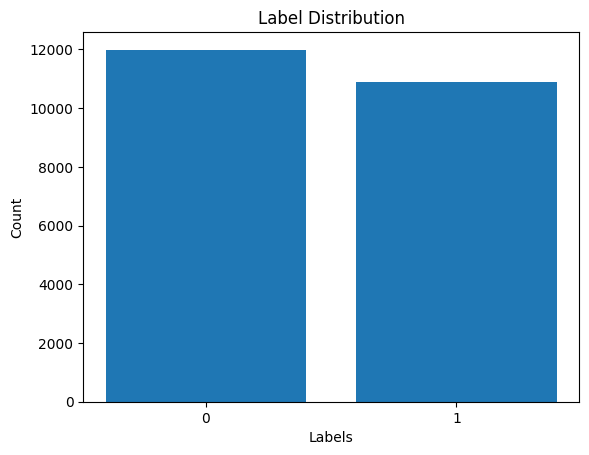

In [205]:
x = df['label'].value_counts()
plt.bar(['0','1'], x)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()


In [27]:
article_text_len

0         6516
1        12055
2         1878
3         7217
4         7453
         ...  
22890        0
22891        0
22892        0
22893        0
22894        0
Name: article_text, Length: 22895, dtype: int64

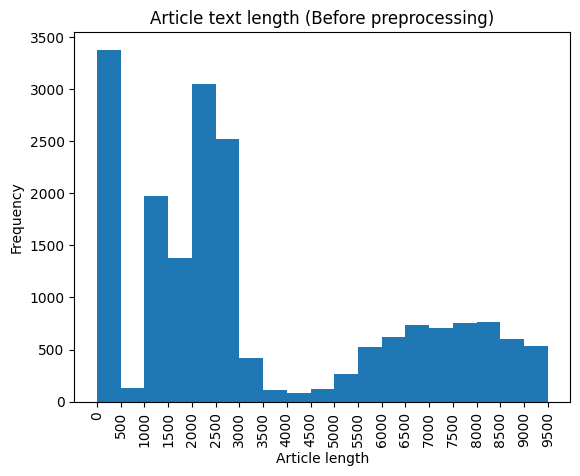

In [206]:
df['article_text'] = df['article_text'].fillna("") 
article_text_len = df['article_text'].apply(lambda x: len(x))
# c = article_text_len.value_counts()/df.shape[0]
plt.hist(article_text_len, bins = range(0,10000,500))
plt.xlabel('Article length')
plt.ylabel('Frequency')
plt.xticks(range(0,10000,500),rotation='vertical')
plt.title('Article text length (Before preprocessing)')
plt.show()

In [193]:
article_text_len.describe()

count    22895.000000
mean      5127.675868
std       5175.379868
min          0.000000
25%       1770.500000
50%       2730.000000
75%       8252.500000
max      99461.000000
Name: article_text, dtype: float64

In [207]:
df.loc[0,'article_text']

"How  Trump  REALLY  Feels  About  Queer  People,  Explained  In  One  Sentence  |  HuffPost  Voices\n\n\n\n\n\n\n\n\n\nSkip  to  Main  Content×Main  MenuU.S.  EditionNewsU.S.  NewsWorld  NewsBusinessEnvironmentHealthSocial  JusticeCrimePoliticsJoe  BidenCongressExtremismOpinionEntertainmentCulture  &  ArtsMediaCelebrityTV  &  FilmBooksLifeStyle  &  BeautyFood  &  DrinkParentingTravelWellnessRelationshipsMoneyHome  &  LivingWork/LifeShoppingVoicesBlack  VoicesQueer  VoicesLatino  VoicesIndigenous  VoicesAsian  VoicesWomen's  VoicesHuffPost  PersonalVIDEOFor  Our  PartnersThe  Good  LifeHoroscopesNewslettersPyramid  Scheme  (Word  Game)InternationalU.S.U.K.EspañaFranceΕλλάδα  (Greece)Italia日本  (Japan)한국  (Korea)Follow  UsTerms\xa0|\xa0Privacy  PolicyPart  of  HuffPost  News.  ©2024  BuzzFeed,  Inc.  All  rights  reserved.×What's  Hot\n\n\n\n\n\n\n\nLog  InSupport  UsQueer  VoicesDonald  TrumpDonald  Trump  LGBTdonald  trump  lgbt  promiseHow  Trump  REALLY  Feels  About  Queer  People, 

# Web Scraping

**As the extraction of text from article link is an independent across all rows,**

**we can use parallel processing across multiple cores using python's multiprocessing library**

In [ ]:
from tqdm import tqdm
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import multiprocessing

# Extract text from row using article link
def extract_text(row):
    site= row[1]
    index = row[3]
    text = [index]
    site_split = site.split('http')
    if(len(site_split)>2):
        site = site.split('https://www.huffingtonpost.com')[1]
    try:
        hdr = {'User-Agent': 'Mozilla/5.0'}
        req = Request(site,headers=hdr)
        page = urlopen(req)
        soup = BeautifulSoup(page, 'html.parser')
        text = [index, soup.get_text()]
    except:
        text= [index,""]
    return text

if __name__ == "__main__":
    
    x = df.to_numpy()
    # Define the number of processes to use
    num_processes = multiprocessing.cpu_count()

    # Create a pool of worker processes
    pool = multiprocessing.Pool(processes=num_processes)

    # Define your input data (e.g., a list of items)
    data = x

    result_list_tqdm = []
    for result in tqdm(pool.imap_unordered(func=extract_text, iterable=data), total=data.shape[0]):
        result_list_tqdm.append(result)
    
    # Close the pool to free up resources
    pool.close()
    pool.join()

In [ ]:
result_list_tqdm

# Pre-processing

In [208]:
# Filling "" in article_text column with na values
df['article_text'] = df['article_text'].fillna("")
def combine(x):
    if x['article_text'] == "":
        x['combined_text'] = x['text']
    else:
        x['combined_text'] = x['article_text']
    return x
df = df.apply(combine,axis=1)

In [209]:
def preprocess(row):
    txt = row['article_text']
    al = row['article_link']
    headline = row['text']
    # replacing \n by space
    txt = txt.replace('\n', " ")
    # replacing multiple spaces by single spacee
    txt = re.sub(r'\s+', ' ', txt)
    # removing huffingtonpost.com from txt
    if("huffingtonpost.com" in al):
        # Splitting at Support HuffPost to remove unwanted footer contents at the end
        split_txt = txt.split('Support HuffPost')
        if len(split_txt)>1:
            txt = split_txt[0]
        # Splitting at Related Content to remove unwanted header contents
    elif("theonion.com" in al):
        split_txt = txt.split('Related Content')
        if len(split_txt)>1:
            txt = split_txt[0]
    try:
        h = headline.lower()
        # replacing multiple spaces by single spacee
        h = re.sub(r'\s+', ' ', h)
        # replacing multiple spaces by single spacee
        h = re.sub(r'\s+', ' ', h)
        txt = re.sub(r'\s+', ' ', txt)
        # formatting
        txt = re.sub("[’‘]","'",txt)
        h = re.sub("[’‘]","'",h)
        # removing html tags
        txt = re.sub(r'<[^>]*>', '', txt)
        txt = txt.lower().split(h)[-1]
        # combining headline and article text 
        txt = h + " " + txt
    except:
        print(row['ID'], h)
        print(txt.lower())
    # removing unwanted text at the starting
    txt = re.sub(r'published.+we may earn a commission from links on this page', '', txt)
    row['article_text'] =txt

        
    return row
    
df = df.apply(preprocess, axis=1)

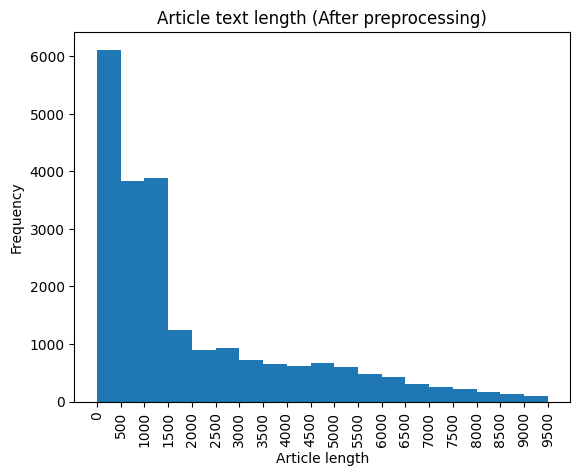

In [203]:
article_text_len = df['article_text'].apply(lambda x: len(x))
# c = article_text_len.value_counts()/df.shape[0]
plt.hist(article_text_len, bins = range(0,10000,500))
plt.xlabel('Article length')
plt.ylabel('Frequency')
plt.xticks(range(0,10000,500),rotation='vertical')
plt.title('Article text length (After preprocessing)')
plt.show()

In [43]:
df.head()

,ID,article_link,text,label,article_text,combined_text
0,4724,https://www.huffingtonpost.com/entry/trump-rea...,how trump really feels about queer peopl...,0,"how trump really feels about queer people, exp...",How Trump REALLY Feels About Queer Peopl...
1,26559,https://www.huffingtonpost.com/entry/egyptian-...,egyptian death sentence for soccer fans ...,0,egyptian death sentence for soccer fans puts p...,Egyptian Death Sentence for Soccer Fans ...
2,24613,https://www.theonion.com/stripper-failing-scho...,stripper failing school she's working sel...,1,stripper failing school she's working self thr...,Stripper Failing School She's Working Sel...
3,9048,https://www.huffingtonpost.com/entry/ken-paxto...,texas attorney general ken paxton indicted,0,texas attorney general ken paxton indicted he ...,Texas Attorney General Ken Paxton Indicte...
4,69,https://www.huffingtonpost.com/entry/debbie-di...,congresswoman fights for gun control beca...,0,congresswoman fights for gun control because s...,Congresswoman Fights For Gun Control Beca...


In [44]:
df.loc[0,'article_text']

"how trump really feels about queer people, explained in one sentence it ain't pretty, folks.by noah michelsoneditorial director, huffpost personaljul 22, 2016, 09:09 am edtleave a commentdon't believe a word this man says.bloomberg via getty imagesdonald trump has vowed to appoint judges who will overturn the supreme court's ruling on marriage equality, has stated that he supports states' rights to pass laws that give permission to discriminate against queer people, and he recently courted 400 of the most anti-queer leaders in america, so his promise to protect queer people (especially as the leader of the republican party which just passed “the most anti-lgbt platform in history”) is nothing but a pile of steaming elephant shit and anyone who tries to tell you otherwise ― including trump himself ― is lying to you and themselves. advertisement editor's note: donald trump regularly incites political violence and is a serial liar, rampant xenophobe, racist, misogynist and birther who ha

In [45]:
df.loc[0,'article_link']

'https://www.huffingtonpost.com/entry/trump-real-feelings-queer-people_us_57920f33e4b00c9876cef2bf'

In [32]:
df.columns

Index(['ID', 'article_link', 'text', 'label', 'article_text', 'combined_text'], dtype='object')

In [46]:
# Dropping multiple columns
df['text']=df['article_text']
df.drop(columns=['ID', 'article_link', 'article_text', 'combined_text'], inplace=True)
df.head()

,text,label
0,"how trump really feels about queer people, exp...",0
1,egyptian death sentence for soccer fans puts p...,0
2,stripper failing school she's working self thr...,1
3,texas attorney general ken paxton indicted he ...,0
4,congresswoman fights for gun control because s...,0


# Splitting Data

In [47]:
from sklearn.model_selection import train_test_split



#(80% train, 20% test)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

#(20% divided into 10%+10%)
# val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)



# Resetting the index of the DataFrame
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)
print("Train set size:", train_df.shape)
print("Validation set size:", val_df.shape)
# print("Test set size:", test_df.shape)

Train set size: (18316, 2)
Validation set size: (4579, 2)


In [48]:
target_list = ['label']
label_dict={0: "label"}

# Model

**Hyperparameters**

In [49]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-04

## Loading BERT Model

In [50]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [52]:
class DatasetClass(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.text = df['text']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            #'targets': torch.FloatTensor(self.targets[index])
            'targets' : torch.FloatTensor(self.targets[index].astype(np.float32))  # Convert to PyTorch FloatTensor
        }

In [53]:
train_dataset = DatasetClass(train_df, tokenizer, MAX_LEN)
valid_dataset = DatasetClass(val_df, tokenizer, MAX_LEN)

In [54]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [55]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [56]:
class FineTunedBERTClass(torch.nn.Module):
    def __init__(self):
        super(FineTunedBERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.linear = torch.nn.Linear(768, 1)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output = self.linear(output.pooler_output)
        return output

In [57]:
model = FineTunedBERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

FineTunedBERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

**We are using Binary Cross Entrpy With Logits as the loss function and Adam optimizer**

Binary Cross Entropy worked better than binary multi label soft margin loss function

In [58]:
def loss_fn_binaryCrossEntropyWithLogits(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# def loss_fn_multiLabelSoftMargin(outputs, targets):
#     return nn.MultiLabelSoftMarginLoss()(outputs, targets)

In [61]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

## Training

In [59]:
import torch
from tqdm import tqdm
import random

# Set the seed for Python's random number generator
seed = 42
random.seed(seed)

# Set the seed for NumPy
np.random.seed(seed)

# Set the seed for PyTorch
torch.manual_seed(seed)

# Set the seed for CUDA (GPU) if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Additional configurations for deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def train_model(n_epochs, training_loader, validation_loader, model, optimizer):
    for epoch in range(1, n_epochs + 1):
        model.train()
        train_loss = 0.0  # Track total training loss for the epoch
        with tqdm(total=len(training_loader), desc=f"Epoch {epoch}/{n_epochs}", unit="batch") as pbar:
            for batch_idx, data in enumerate(training_loader):
                ids = data['input_ids'].to(device)
                mask = data['attention_mask'].to(device)
                token_type_ids = data['token_type_ids'].to(device)
                targets = data['targets'].to(device)

                optimizer.zero_grad()
                outputs = model(ids, mask, token_type_ids)
                loss = loss_fn_binaryCrossEntropyWithLogits(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * len(ids)  # Accumulate the training loss for the batch
                pbar.set_postfix({'Training Loss': train_loss / len(training_loader.dataset)})
                pbar.update()

        # Calculate average training loss for the epoch
        train_loss /= len(training_loader.dataset)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in validation_loader:
                ids = data['input_ids'].to(device)
                mask = data['attention_mask'].to(device)
                token_type_ids = data['token_type_ids'].to(device)
                targets = data['targets'].to(device)

                outputs = model(ids, mask, token_type_ids)
                loss = loss_fn_binaryCrossEntropyWithLogits(outputs, targets)
                val_loss += loss.item() * len(ids)

        # Calculate average validation loss for the epoch
        val_loss /= len(validation_loader.dataset)

        print(f"Epoch {epoch}/{n_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


In [62]:
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer)

Epoch 1/2: 100%|██████████| 573/573 [11:46<00:00,  1.23s/batch, Training Loss=0.0897]


Epoch 1/2, Training Loss: 0.0897, Validation Loss: 0.0596


Epoch 2/2: 100%|██████████| 573/573 [11:47<00:00,  1.23s/batch, Training Loss=0.0628] 


Epoch 2/2, Training Loss: 0.0628, Validation Loss: 0.0834


In [103]:
torch.save(model.state_dict(), '/kaggle/working/my_model_bert.pth')

**Testing** -> Use Inference Script to load model and test

# Testing

In [139]:
test_df2 = pd.read_csv("/kaggle/input/sarcasmdetect/test_data.csv")
test_df2.shape

(5724, 3)

In [165]:
import pandas as pd

# Read the CSV file into DataFrame
test_df = pd.read_csv("/kaggle/input/sarcasm-scraped-new/data/sarcasm_scraped_test.csv")

In [160]:
test_df.isnull().sum()

ID               0
article_link     2
text             2
article_text    60
dtype: int64

In [166]:
test_df = test_df[~(test_df['article_link'].isnull())]

In [169]:
test_df = test_df.reset_index()

In [171]:
test_df.drop(['index'], axis =1, inplace = True)

In [172]:
test_df.isnull().sum()

ID               0
article_link     0
text             0
article_text    58
dtype: int64

In [173]:
# Fill missing values in 'article_text' column with empty strings
test_df['article_text'] = test_df['article_text'].fillna("")
test_df['text'] = test_df['text'].fillna("")


# Define a function to combine 'text' and 'article_text' columns
def combine(x):
    if x['article_text'] == "":
        return x['text']
    else:
        return x['article_text']

# Apply the combine function to create the 'combined_text' column
test_df['combined_text'] = test_df.apply(combine, axis=1)

In [174]:
test_df = test_df.apply(preprocess, axis=1)

In [80]:
test_df.head()

,ID,article_link,text,article_text,combined_text
0,27927,https://www.huffingtonpost.com/entry/teacher-e...,states slow to shut down weak teacher educatio...,states slow to shut down weak teacher educatio...,States Slow To Shut Down Weak Teacher Educatio...
1,1660,https://www.theonion.com/drone-places-fresh-ki...,drone places fresh kill on steps of white house,drone places fresh kill on steps of white house .,Drone Places Fresh Kill On Steps Of White Hous...
2,96,https://www.theonion.com/report-majority-of-in...,report: majority of instances of people gettin...,report: majority of instances of people gettin...,Report: Majority Of Instances Of People Gettin...
3,6237,https://local.theonion.com/sole-remaining-lung...,"sole remaining lung filled with rich, satisfyi...","sole remaining lung filled with rich, satisfyi...","Sole Remaining Lung Filled With Rich, Satisfyi..."
4,6650,https://www.huffingtonpost.com/entry/the-gops-...,the gop's stockholm syndrome,the gop's stockholm syndrome like many victims...,The GOP's Stockholm Syndrome | HuffPost Latest...


In [82]:
test_df.columns

Index(['ID', 'article_link', 'text', 'article_text', 'combined_text'], dtype='object')

In [175]:

# Dropping multiple columns
test_df['text']=test_df['article_text']
test_df.drop(columns=['article_link', 'article_text', 'combined_text'], inplace=True)
test_df.head()

,ID,text
0,27927,states slow to shut down weak teacher educatio...
1,1660,drone places fresh kill on steps of white house .
2,96,report: majority of instances of people gettin...
3,6237,"sole remaining lung filled with rich, satisfyi..."
4,6650,the gop's stockholm syndrome like many victims...


In [176]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [177]:
class DatasetClass(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.text = df['text']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten()
        }


In [178]:
test_dataset = DatasetClass(test_df, tokenizer, MAX_LEN)

In [179]:
MAX_LEN=256
TEST_BATCH_SIZE=32

In [180]:
test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [181]:
#global all_targets
global all_outputs

In [182]:
#all_targets = []
all_outputs = []

In [183]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from tabulate import tabulate


def evaluate_model(model, dataloader, all_outputs):
    model.eval()
    #all_targets = []
    #all_outputs = []

    with torch.no_grad():
        for data in dataloader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            #targets = data['targets'].to(device, dtype=torch.float)
            
            outputs = model(ids, mask, token_type_ids)
            
            #all_targets.extend(torch.tensor(targets.cpu().detach().numpy()))
            all_outputs.extend(torch.round(torch.tensor(torch.sigmoid(outputs).cpu().detach().numpy())))

    #all_targets = np.array(all_targets)
    all_outputs = np.array(all_outputs)

        
    print("Predicted Output:\n",all_outputs[:5])
    
    return all_outputs


In [184]:
predicted_output=evaluate_model(model, test_data_loader, all_outputs)

Predicted Output:
 [[0.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [185]:
print(predicted_output)

[[0.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


In [186]:
# Assuming you have 'predicted_output' as a list containing the predicted values

# Append 'pred_output' column to the DataFrame
test_df['pred_output'] = predicted_output

# Drop the 'text' column
test_df.drop(columns=['text'], inplace=True)


In [95]:
test_df.head()

,ID,pred_output
0,27927,0.0
1,1660,1.0
2,96,1.0
3,6237,1.0
4,6650,0.0


In [187]:
# Append 'pred_output' column to the DataFrame
test_df['label'] = test_df['pred_output']
# Drop the 'text' column
test_df.drop(columns=['pred_output'], inplace=True)

In [97]:
test_df.head()

,ID,label
0,27927,0.0
1,1660,1.0
2,96,1.0
3,6237,1.0
4,6650,0.0


In [188]:
# Save the modified DataFrame to a CSV file
test_df.to_csv("sarcasm_submission_v3_2023EET2176_2023EET2190.csv", index=False)

2 rows are non-sense. Our output shape should be (5724,2) but shape is showing as (5726, 2). Manually removed them. Need to see how they crept it. Probably it's the delimiter thing again.

In [101]:
test_df.shape

(5726, 2)

In [100]:
test_df['label'].unique()

array([0., 1.], dtype=float32)